# Gesture Recognition
The primary goal of this study is to design, develop, and validate a comprehensive deep learning framework that enables smart televisions to detect and interpret five distinct hand gestures in real time, thereby orchestrating a paradigm shift in how users interact with their televisions. To provide a fun feature for the smart-TV that is capable of recognising five various gestures that are done by the user, which will assist users in controlling the TV without the usage of a remote

In [17]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


In [18]:
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable


In [41]:
import imageio.v2 as imageio

image = imageio.imread(r'C:\Users\kevin\Desktop\Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00016.png')


In [42]:
import numpy as np
import os
import datetime
import os
from skimage.transform import resize

The random seed set so that the results don't vary drastically.

In [43]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

The below code reads and shuffles the lines from 'train.csv' and 'val.csv' files, storing them in train_doc and val_doc respectively, and sets a batch size of 16 for training.

In [44]:
train_doc = np.random.permutation(open('C:/Users/kevin/Desktop/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/kevin/Desktop/Project_data/val.csv').readlines())
batch_size = 16

## Generator
This is one of the most crucial sections of the code. The generator's overall architecture has been provided. As there are images of two different dimensions, the generator will preprocess the images and produce a batch of video frames. It is necessary experiment with certain aspects of the generator function to achieve high precision.

In [45]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size)
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,15,120,120,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    if image.shape[1] == 160:
                        image = image[:,20:140,:].astype(np.float32)
                    else:
                        image = resize(image,(120,120)).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [46]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/kevin/Desktop/Project_data/train'
val_path = 'C:/Users/kevin/Desktop/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 70
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 70


## Model CNN+RNN

Keras is used to construct a hybrid model that combines convolutional VGG16 layers with recurrent GRU layers. Initialised with 'imagenet' weights, VGG16 functions as an image feature extractor. The extracted features are then fed through a series of layers, including GRUs, in order to analyse temporal patterns in image sequences. The output is intended to categorise each sequence into one of five categories.


In [47]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications.vgg16 import VGG16
    
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(120,120,3))
x = base_model.output
x = Flatten()(x)
#x.add(Dropout(0.5))
features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model = Sequential()
model.add(TimeDistributed(conv_model, input_shape=(15,120,120,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [48]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate=0.001, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 15, 64)            15009664  
 stributed)                                                      
                                                                 
 gru_6 (GRU)                 (None, 15, 32)            9408      
                                                                 
 gru_7 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 5)                 45        
                                                      

By configuring these generators, the code facilitates the efficient and dynamic loading of training and validation data during the training process of the model.

In [49]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [50]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [53]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Trains the neural network model using data from train_generator, specifying the number of training steps per epoch, total epochs, and other training parameters, while also validating the model using val_generator after each epoch.

In [54]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/70
42/42 [==============================] - ETA: 0s - loss: 1.6573 - categorical_accuracy: 0.2459 Source path =  C:/Users/kevin/Desktop/Project_data/val ; batch size = 16

Epoch 1: saving model to model_init_conv_lstm_2023-08-2719_25_31.579951\model-00001-1.65731-0.24585-1.59609-0.26000.h5
42/42 [==============================] - 601s 14s/step - loss: 1.6573 - categorical_accuracy: 0.2459 - val_loss: 1.5961 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/70


C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - ETA: 0s - loss: 1.5990 - categorical_accuracy: 0.2640 
Epoch 2: saving model to model_init_conv_lstm_2023-08-2719_25_31.579951\model-00002-1.59896-0.26395-1.56044-0.33000.h5
42/42 [==============================] - 591s 14s/step - loss: 1.5990 - categorical_accuracy: 0.2640 - val_loss: 1.5604 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 3/70
42/42 [==============================] - ETA: 0s - loss: 1.4488 - categorical_accuracy: 0.3454 
Epoch 3: saving model to model_init_conv_lstm_2023-08-2719_25_31.579951\model-00003-1.44883-0.34540-1.40339-0.36000.h5
42/42 [==============================] - 601s 14s/step - loss: 1.4488 - categorical_accuracy: 0.3454 - val_loss: 1.4034 - val_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 4/70
42/42 [==============================] - ETA: 0s - loss: 1.3399 - categorical_accuracy: 0.4540 
Epoch 4: saving model to model_init_conv_lstm_2023-08-2719_25_31.579951\model-00004-1.33987-0.45400-1.32468-0.50000.

In [55]:
import matplotlib.pyplot as plt

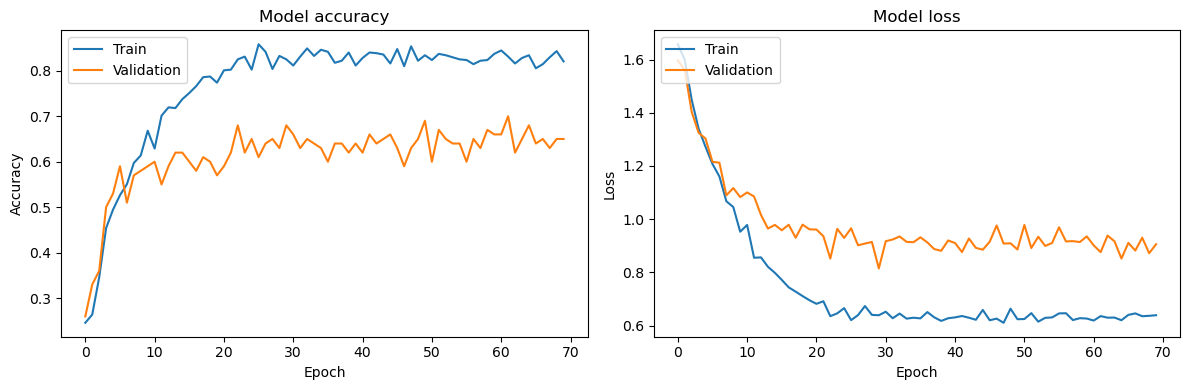

In [56]:
def plot(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot(history)


In [57]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


In [58]:
# Extract the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# If you also tracked accuracy (or other metrics), you can extract them too:
train_accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

In [59]:
# Using your validation generator
val_loss, val_accuracy = model.evaluate(val_generator, steps=validation_steps)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')


7/7 [==============================] - 77s 11s/step - loss: 0.9574 - categorical_accuracy: 0.6300
Validation Loss: 0.9574403166770935
Validation Accuracy: 0.6299999952316284


In [71]:
# Save the model for later use
model.save('Gesture_CNN+RNN.h5')

C:\Users\kevin\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
